# Regression

## End to End Machine Learning Project
#### We are going to follow these steps to build an end to end house price prediction model.
    - Data Discovery
    - Exploratory Data Analysis (EDA)
    - Data Pre-processing
    - Feature Selection
    - Modelling and Hyperparameter tuning.
    - Conclusion

- Here's the [**Data set:** ](https://www.kaggle.com/datasets/yasserh/housing-prices-dataset)

In [78]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.feature_selection import RFE
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.linear_model import LinearRegression,Ridge,Lasso
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.ensemble import RandomForestRegressor

### 1. Data Discovery

In [2]:
# Load the dataset
df = pd.read_csv("Housing.csv")
features = df.drop(["price"], axis=1)
target = df.drop(features.columns, axis=1)

print(f"\n\033[1mFindings:\033[0m The dataset consists of {df.shape[0]} rows and {df.shape[1]} columns")
df.head()


Findings: The dataset consists of 545 rows and 13 columns


,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
0,13300000,7420.0,4.0,2,3,yes,no,no,no,yes,2,yes,furnished
1,12250000,8960.0,4.0,4,4,yes,no,no,no,yes,3,no,furnished
2,12250000,9960.0,3.0,2,2,yes,no,yes,no,no,2,yes,semi-furnished
3,12215000,7500.0,4.0,2,2,yes,no,yes,no,yes,3,yes,furnished
4,11410000,7420.0,4.0,1,2,yes,yes,yes,no,yes,2,no,furnished


In [3]:
# Check data summary
features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 545 entries, 0 to 544
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   area              541 non-null    float64
 1   bedrooms          542 non-null    float64
 2   bathrooms         545 non-null    int64  
 3   stories           545 non-null    int64  
 4   mainroad          543 non-null    object 
 5   guestroom         545 non-null    object 
 6   basement          543 non-null    object 
 7   hotwaterheating   545 non-null    object 
 8   airconditioning   545 non-null    object 
 9   parking           545 non-null    int64  
 10  prefarea          545 non-null    object 
 11  furnishingstatus  545 non-null    object 
dtypes: float64(2), int64(3), object(7)
memory usage: 51.2+ KB


In [4]:
no_num_features = 0
no_cat_features = 0
num_features = []
cat_features = []

for col in features.columns:
    if features[col].nunique() > 16:
        no_num_features += 1
        num_features.append(col)
    elif features[col].nunique() <= 16:
        no_cat_features += 1
        cat_features.append(col)
print(f"\n\033[1mFindings:\033[0m There are {no_num_features} numerical variables and {no_cat_features} categorical variables.")


Findings: There are 1 numerical variables and 11 categorical variables.


### 2. Exploratory Data Analysis

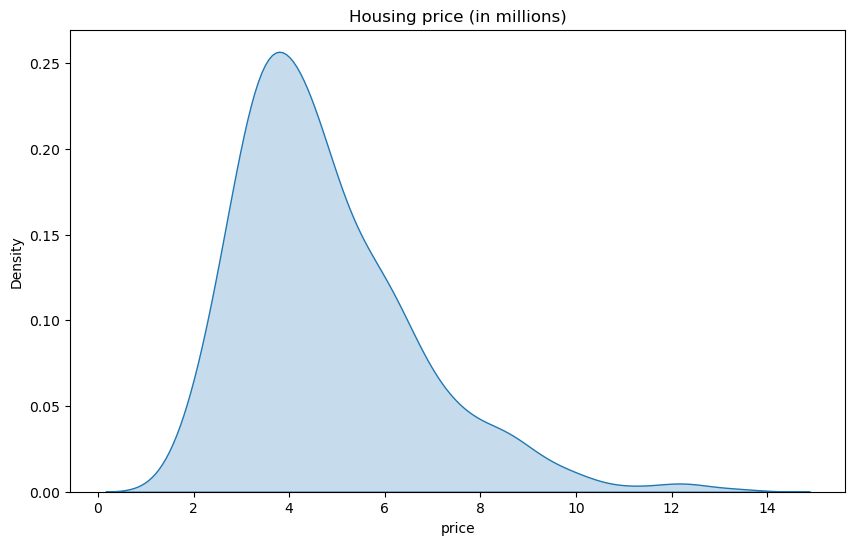

In [5]:
# Let's look at the target variable first
plt.rcParams['figure.figsize'] = [10,6]
sns.kdeplot(x=target["price"]/1000000, shade=True)
plt.title("Housing price (in millions)")
plt.show()

In [6]:
print(f"\n\033[1mFindings:\033[0m The target variable is almost normally distributed.")


Findings: The target variable is almost normally distributed.


In [1]:
# Visualizing categorical features
plt.figure(figsize = (16, 20))
plotnumber = 1

for i in range(1, len(cat_features)):
    if plotnumber <= 10:
        ax = plt.subplot(6, 2, plotnumber)
        sns.countplot(x = cat_features[i], data = features, ax = ax)
        plt.title(f"\n{cat_features[i]} \n", fontsize = 20)
        
    plotnumber += 1

plt.tight_layout()
plt.show()

NameError: name 'plt' is not defined

In [8]:
num_features

['area']

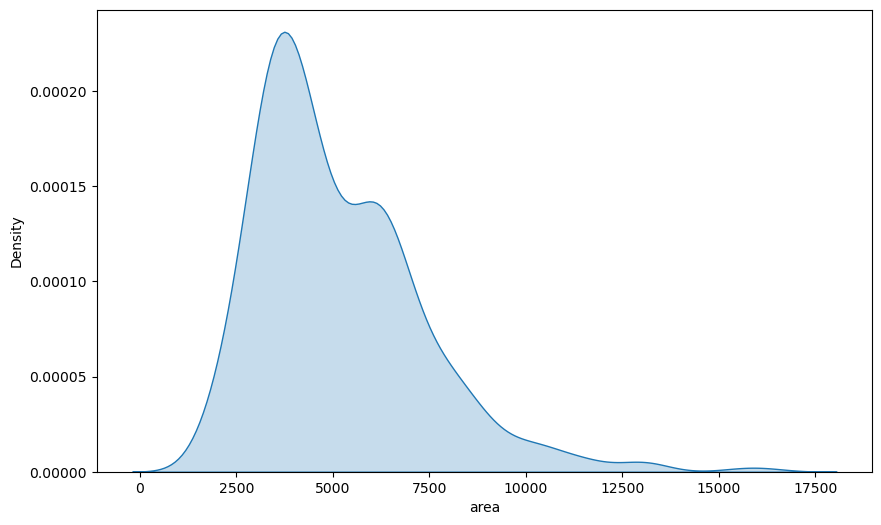

In [9]:
# Visualizing Numerical Variables
sns.kdeplot(x=features[num_features[0]], shade=True)
plt.show()

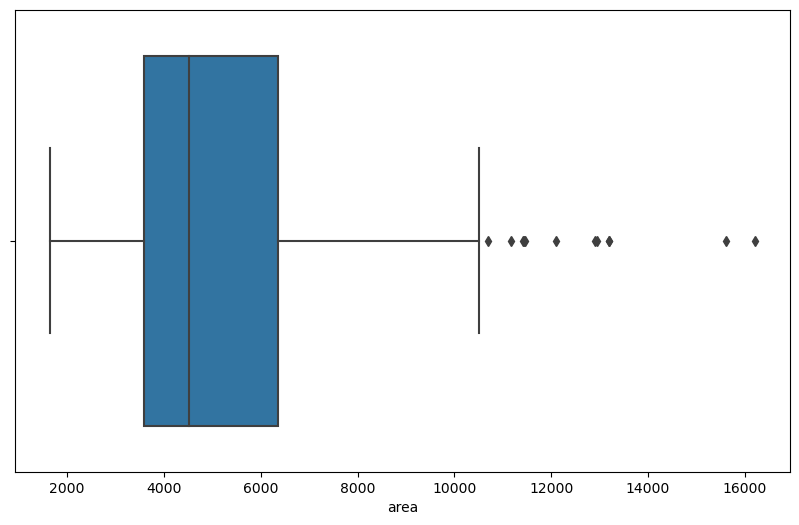

In [10]:
sns.boxplot(x=features[num_features[0]])
plt.show()

**Findings** The area variable has outlier, we're going to deal with them later.

In [11]:
# Check with duplicates
duplicates = df.duplicated().sum()
print(f"The number of duplicates in our data is {duplicates}")
print(f"\n\033[1mFindings:\033[0m We do not have any duplicate values in our data")

The number of duplicates in our data is 0

Findings: We do not have any duplicate values in our data


In [12]:
# Check for missing values
missing=df.isnull().sum().reset_index()
missing.columns = ["column_name", "missing_vals"]
missing["column_type"] = missing["column_name"].apply(lambda x: 'Category' if x in cat_features else "Numeric")
missing_columns = missing[missing["missing_vals"] > 0].reset_index(drop=True)
print(missing_columns)
print(f"\n\033[1mFindings:\033[0m We 4 columns with missing values in our data.\
\nOne is numeric, rest are categorical.\
\nWe'll take care of them in the preprocessing step.")

  column_name  missing_vals column_type
0        area             4     Numeric
1    bedrooms             3    Category
2    mainroad             2    Category
3    basement             2    Category

Findings: We 4 columns with missing values in our data.
One is numeric, rest are categorical.
We'll take care of them in the preprocessing step.


In [13]:
# Find variables with negative values
for col in df.columns:
    if df[col].dtype != "object":
        total_neg = (df[col]<0)
        print(f"{col} has {total_neg.sum()} negative value")

price has 0 negative value
area has 0 negative value
bedrooms has 0 negative value
bathrooms has 0 negative value
stories has 0 negative value
parking has 0 negative value


### 3. Data Preprocessing

#### 1. Remove Outliers from the "area" variable
* We will remove all data values that extend beyond 1.5 times the IQR from Q1 and Q3

In [14]:
for ft in num_features:
    q1 = df[ft].quantile(.25)
    q3 = df[ft].quantile(.75)
    iqr = q3-q1
    factor = iqr*1.5
    lower_limit = q1 - factor
    upper_limit = q3 + factor
    df = df[(df[ft] > lower_limit) & (df[ft] < upper_limit)]

In [15]:
df.shape

(529, 13)

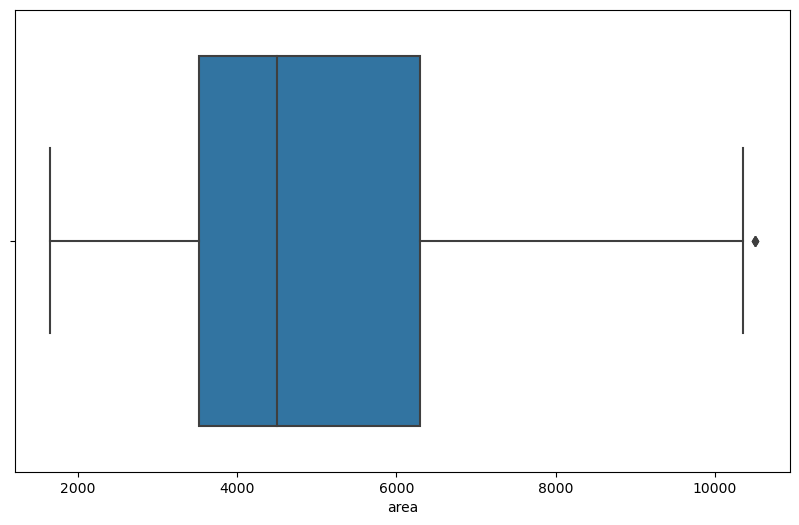

In [16]:
sns.boxplot(x=df[num_features[0]])
plt.show()

**Before removing outliers, we had 545 rows, now we are left with 529**
* From the boxplot, the number of outliers has be significantly reduced compared to what we had before.

#### 2. Train Split
* Let split our training data and our test before imputation of missing values to avoid train-test contamination.

In [2]:
X_train, X_test, y_train, y_test = train_test_split(df[features.columns], df[target.columns], test_size=0.2, random_state=100)

NameError: name 'train_test_split' is not defined

In [43]:
y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)
print(f"Train | X->{X_train.shape}, y->{y_train.shape}")
print(f"Test | X->{X_test.shape}, y->{y_test.shape}")

Train | X->(423, 12), y->(423, 1)
Test | X->(106, 12), y->(106, 1)


#### 3. Impute Missing Values.
* From our previous step, we know that we have 1 numerical(area) and 3 categorical(bedrooms, mainroad, basement) variables with missing values.
* We need to encode them separately.
* The numerical variable has some outliers and and the distribution is not normal, so a mean would not a good representation of the variable.
* Therefore, we are going to use the median for imputation for the numeric variable.
* For the 3 categorical variables, let's use the most frequent value for imputation.

In [19]:
num_imputer = SimpleImputer(strategy="median")
cat_imputer = SimpleImputer(strategy="most_frequent")
num_col_with_na = missing_columns[missing_columns["column_type"] == "Numeric"].loc[0,"column_name"]
cat_cols_with_na = missing_columns[missing_columns["column_type"] == "Category"].loc[:,"column_name"].values

In [20]:
df.isnull().sum()

price               0
area                0
bedrooms            1
bathrooms           0
stories             0
mainroad            2
guestroom           0
basement            1
hotwaterheating     0
airconditioning     0
parking             0
prefarea            0
furnishingstatus    0
dtype: int64

In [21]:
# Numeric variable imputation
def num_impute(data):
    data = data.reset_index(drop=True)
    num_missing = pd.DataFrame(data.loc[:,num_col_with_na], columns=["area"])
    num_imputed = num_imputer.fit_transform(num_missing)
    data["area"] = num_imputed
    return data
X_train = num_impute(X_train)
X_test = num_impute(X_test)

In [22]:
# Categorical Imputation
def cat_impute(data):
    data = data.reset_index(drop=True)
    cat_missing = data[cat_cols_with_na]
    cat_imputed = pd.DataFrame(cat_imputer.fit_transform(cat_missing))
    cat_imputed.columns = cat_cols_with_na
    data.drop(cat_cols_with_na, axis=1, inplace=True)
    data[cat_cols_with_na] = cat_imputed
    data["bedrooms"] = pd.to_numeric(data["bedrooms"])
    return data
X_train_imputed = cat_impute(X_train)
X_test_imputed = cat_impute(X_test)

In [23]:
X_train_imputed.isnull().sum()

area                0
bathrooms           0
stories             0
guestroom           0
hotwaterheating     0
airconditioning     0
parking             0
prefarea            0
furnishingstatus    0
bedrooms            0
mainroad            0
basement            0
dtype: int64

In [24]:
X_test_imputed.isnull().sum()

area                0
bathrooms           0
stories             0
guestroom           0
hotwaterheating     0
airconditioning     0
parking             0
prefarea            0
furnishingstatus    0
bedrooms            0
mainroad            0
basement            0
dtype: int64

In [25]:
X_test_imputed.head()

,area,bathrooms,stories,guestroom,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus,bedrooms,mainroad,basement
0,3060.0,1,1,no,no,no,0,no,unfurnished,3.0,yes,no
1,5200.0,1,3,no,no,no,0,no,unfurnished,4.0,yes,no
2,5880.0,1,1,no,no,no,1,no,unfurnished,3.0,yes,no
3,5400.0,1,1,no,no,no,3,no,semi-furnished,3.0,yes,no
4,4992.0,2,2,no,no,no,2,no,unfurnished,3.0,yes,no


In [26]:
X_train_imputed.head()

,area,bathrooms,stories,guestroom,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus,bedrooms,mainroad,basement
0,3600.0,1,2,no,no,no,1,no,unfurnished,6.0,yes,no
1,4075.0,1,1,yes,no,no,2,no,semi-furnished,3.0,yes,yes
2,2787.0,1,1,no,no,no,0,yes,furnished,3.0,yes,yes
3,8960.0,4,4,no,no,yes,3,no,furnished,4.0,yes,no
4,6000.0,2,4,no,no,yes,0,no,unfurnished,4.0,yes,no


**As you can see, we don't have missing values any more**
* Now let move to encoding categorical variables.

#### 4. Categorical Encoding
* For categorical encoding, we are going to use the onehot encoder since the number of classes in all categorical variables are relatively few.
* However, some categories are already encoded like bedroom, bathroom, stories and parking. Were are not going to encode them since they are all ordinal variables, retaining the natural hierarchy is important.

In [27]:
pre_encoded_cats = [col for col in df.columns if df[col].dtype == "object"]
ohe=OneHotEncoder(drop='first',sparse=False)

In [28]:
def cat_encoding(data):
    cat_to_encode = data[pre_encoded_cats]
    encoded = ohe.fit_transform(cat_to_encode)
    encoded_df = pd.DataFrame(index=data.index, data=encoded, columns=ohe.get_feature_names_out(pre_encoded_cats))
    data.drop(pre_encoded_cats, axis=1, inplace=True)
    data = pd.concat([data, encoded_df], axis=1)
    return data

In [29]:
X_train_encoded = cat_encoding(X_train_imputed)
X_test_encoded = cat_encoding(X_test_imputed)

In [30]:
X_train_encoded.head()

,area,bathrooms,stories,parking,bedrooms,mainroad_yes,guestroom_yes,basement_yes,hotwaterheating_yes,airconditioning_yes,prefarea_yes,furnishingstatus_semi-furnished,furnishingstatus_unfurnished
0,3600.0,1,2,1,6.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,4075.0,1,1,2,3.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0
2,2787.0,1,1,0,3.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
3,8960.0,4,4,3,4.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,6000.0,2,4,0,4.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0


In [31]:
X_test_encoded.head()

,area,bathrooms,stories,parking,bedrooms,mainroad_yes,guestroom_yes,basement_yes,hotwaterheating_yes,airconditioning_yes,prefarea_yes,furnishingstatus_semi-furnished,furnishingstatus_unfurnished
0,3060.0,1,1,0,3.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,5200.0,1,3,0,4.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,5880.0,1,1,1,3.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,5400.0,1,1,3,3.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,4992.0,2,2,2,3.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


#### 5. Scaling
* Let's scale all our variables to a common scale to prevent the variables with bigger scale e.g area from dominating over those with smaller scales.

In [32]:
scaler = StandardScaler()

In [33]:
def scale_data(data):
    scaled = scaler.fit_transform(data)
    scaled = pd.DataFrame(scaled)
    scaled.columns = data.columns
    return scaled
X_train_scaled = scale_data(X_train_encoded)
X_test_scaled = scale_data(X_test_encoded)

In [34]:
X_train_scaled.head()

,area,bathrooms,stories,parking,bedrooms,mainroad_yes,guestroom_yes,basement_yes,hotwaterheating_yes,airconditioning_yes,prefarea_yes,furnishingstatus_semi-furnished,furnishingstatus_unfurnished
0,-0.744761,-0.591806,0.256656,0.390637,4.161548,0.41833,-0.460472,-0.745082,-0.234228,-0.684653,-0.505166,-0.869015,1.437086
1,-0.489091,-0.591806,-0.898297,1.562549,0.086699,0.41833,2.171685,1.342134,-0.234228,-0.684653,-0.505166,1.150728,-0.695852
2,-1.182361,-0.591806,-0.898297,-0.781274,0.086699,0.41833,-0.460472,1.342134,-0.234228,-0.684653,1.979547,-0.869015,-0.695852
3,2.140274,5.321595,2.566563,2.734460,1.444982,0.41833,-0.460472,-0.745082,-0.234228,1.460593,-0.505166,-0.869015,-0.695852
4,0.547046,1.379328,2.566563,-0.781274,1.444982,0.41833,-0.460472,-0.745082,-0.234228,1.460593,-0.505166,-0.869015,1.437086


In [35]:
X_test_scaled.head()

,area,bathrooms,stories,parking,bedrooms,mainroad_yes,guestroom_yes,basement_yes,hotwaterheating_yes,airconditioning_yes,prefarea_yes,furnishingstatus_semi-furnished,furnishingstatus_unfurnished
0,-1.005938,-0.505179,-1.048695,-0.843848,-0.064458,0.390095,-0.49705,-0.657596,-0.138675,-0.64291,-0.702109,-0.762948,1.365601
1,0.145062,-0.505179,1.267173,-0.843848,1.302061,0.390095,-0.49705,-0.657596,-0.138675,-0.64291,-0.702109,-0.762948,1.365601
2,0.510801,-0.505179,-1.048695,0.302920,-0.064458,0.390095,-0.49705,-0.657596,-0.138675,-0.64291,-0.702109,-0.762948,1.365601
3,0.252633,-0.505179,-1.048695,2.596454,-0.064458,0.390095,-0.49705,-0.657596,-0.138675,-0.64291,-0.702109,1.310705,-0.732279
4,0.033189,1.636781,0.109239,1.449687,-0.064458,0.390095,-0.49705,-0.657596,-0.138675,-0.64291,-0.702109,-0.762948,1.365601


### 4. Feature Selection
* Now lets select the most important features.

#### 1. Correlation
* Check for correlation between the predictor variable.
* Since this is a regression problem we want to check for multicollinearity.

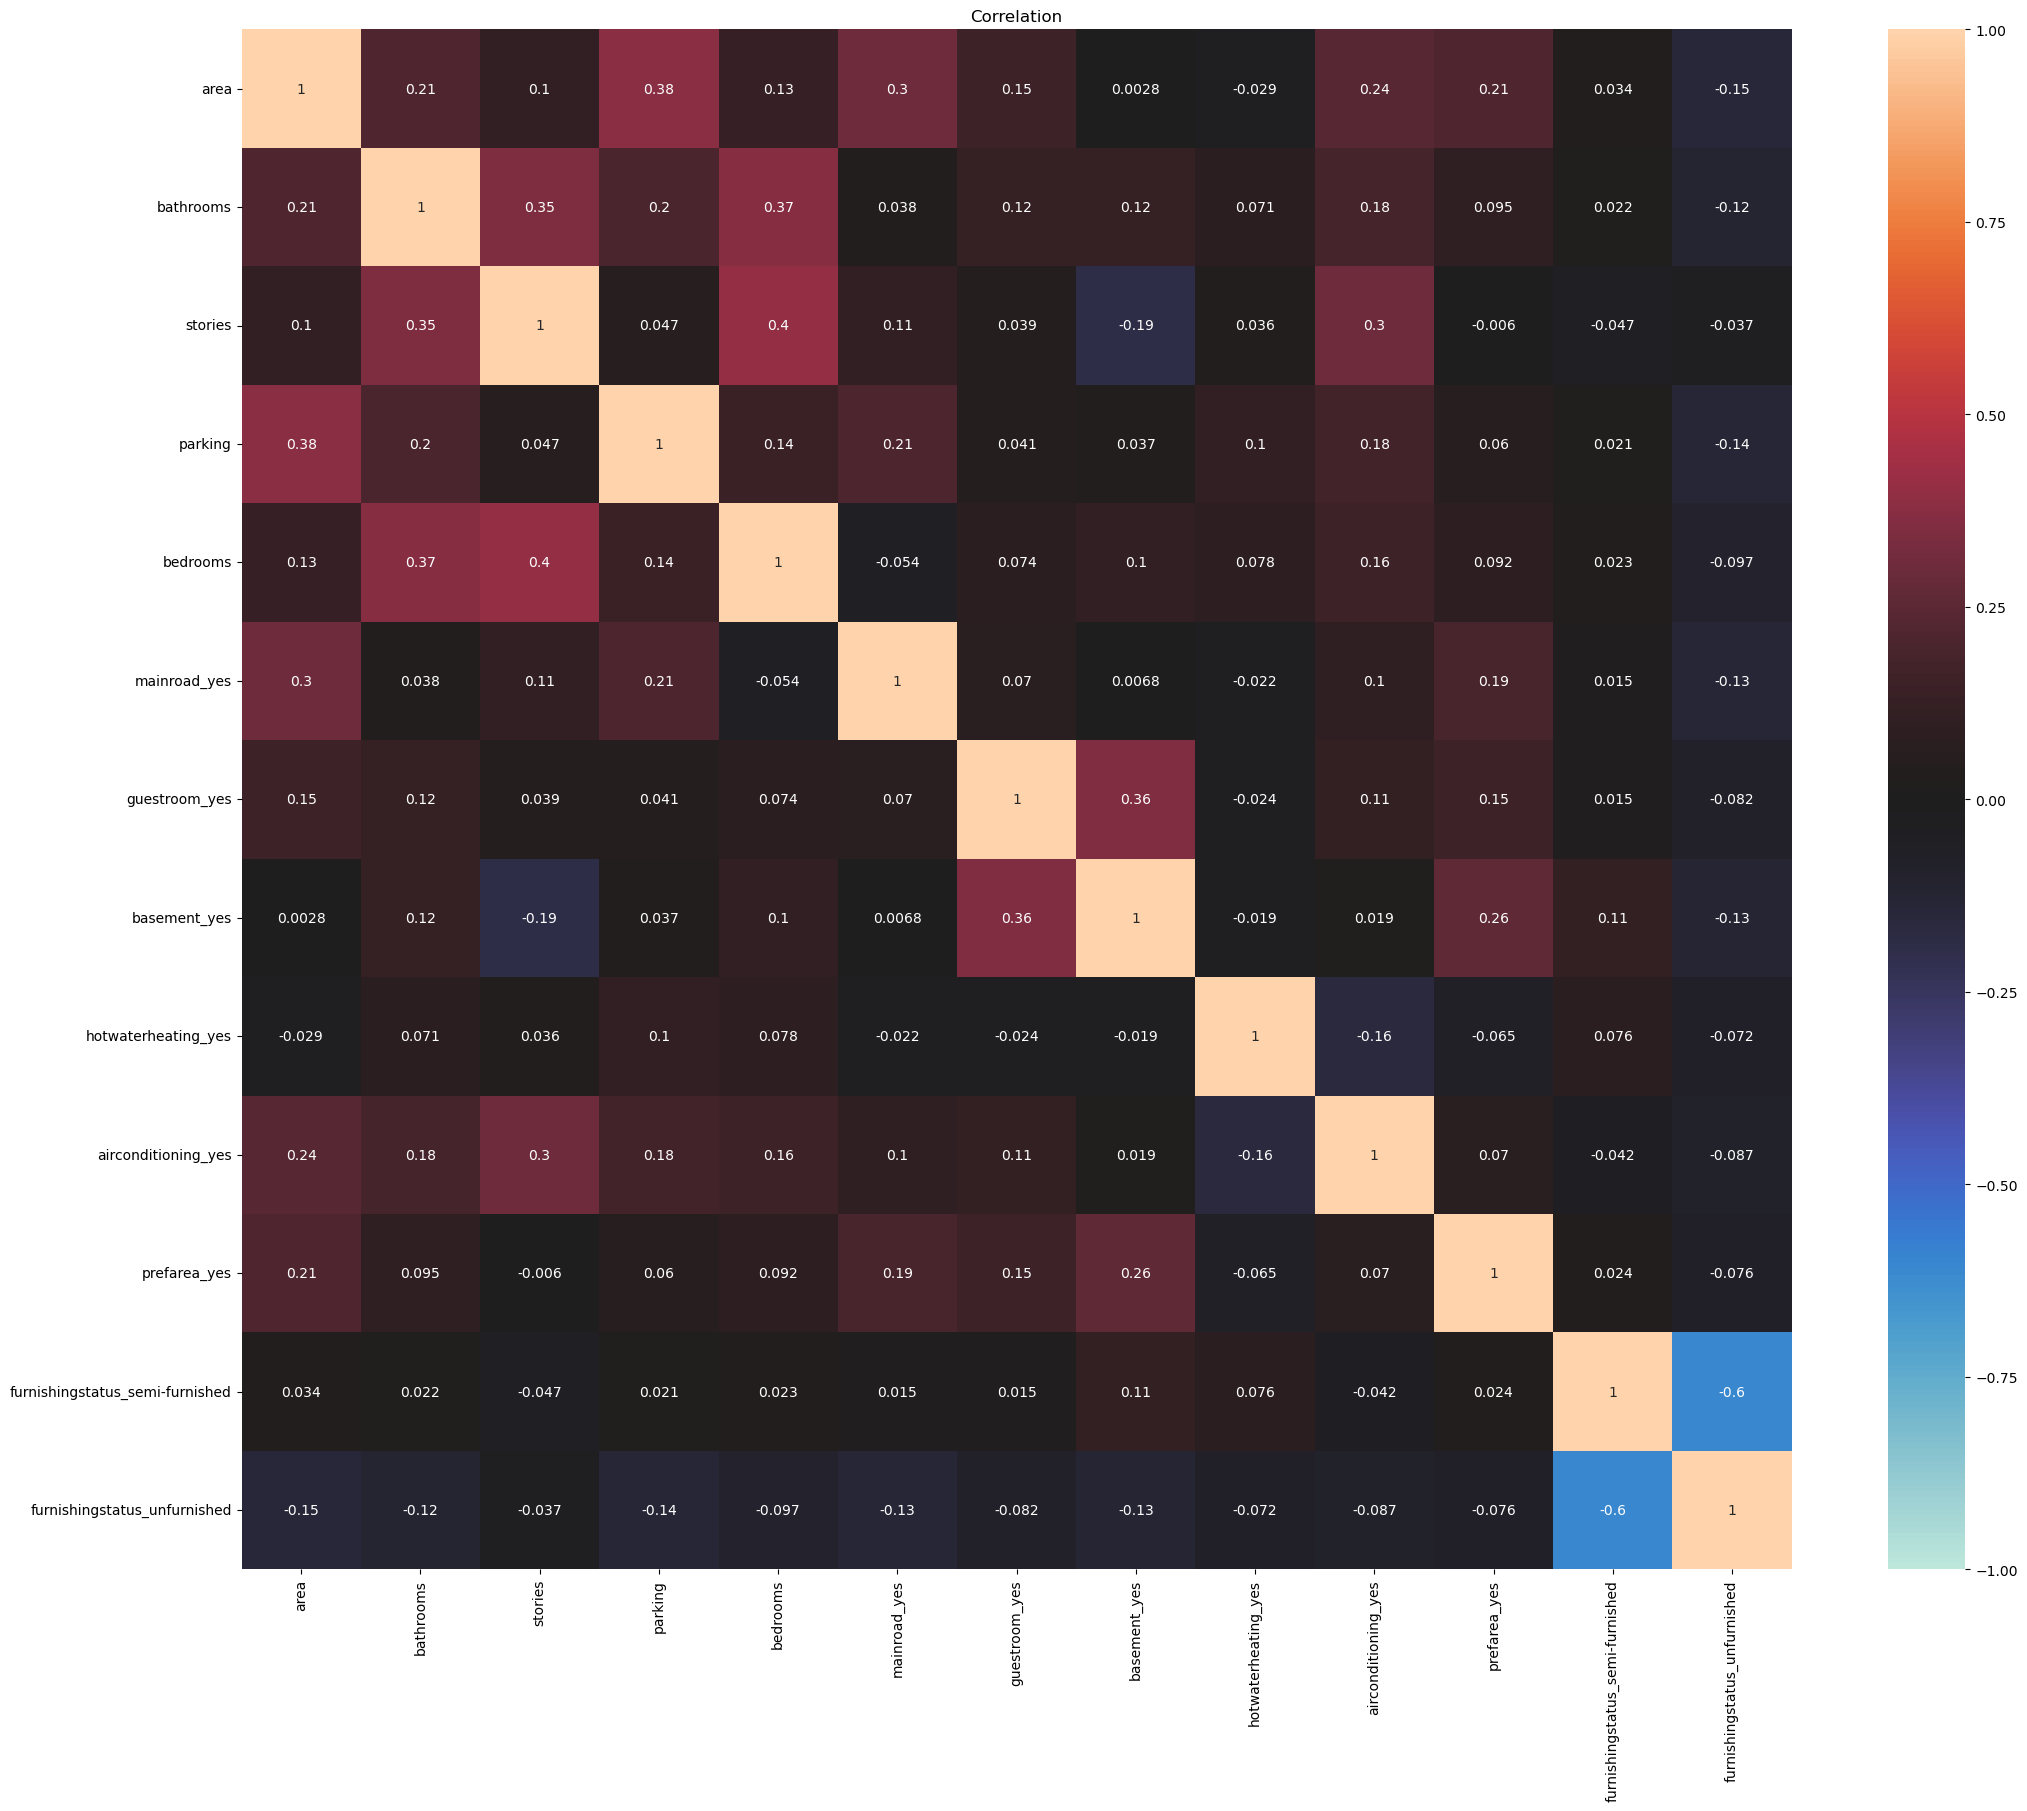

In [37]:
plt.figure(figsize=(25,20))
sns.heatmap(X_train_scaled.corr(), annot=True, vmin=-1, vmax=1, center=0)
plt.title("Correlation")
plt.show()

**There seems to be a few predictor variables with strong correlation, let's investigate this a little bit more**

#### Using Variance Inflation Factor
* Variance inflation factor (VIF) is a statistical measure that assesses the extent to which the variance of the estimated regression coefficient is inflated due to multicollinearity in a multiple regression model.
* A high VIF value indicates that the independent variable is highly correlated with other independent variables in the model and that its contribution to the model may not be unique. 
* A VIF value greater than 5 or 10 is usually considered problematic and suggests that the independent variable should be removed from the model to avoid multicollinearity issues.

In [77]:
# Calculate the VIF for each independent variable
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X_train_scaled.values, i) for i in range(X_train_scaled.shape[1])]
vif["Features"] = X_train_scaled.columns

# Print the VIF values for each independent variable
print(vif)

    VIF Factor                         Features
0     1.377411                             area
1     1.327149                        bathrooms
2     1.518605                          stories
3     1.258647                          parking
4     1.369921                         bedrooms
5     1.195066                     mainroad_yes
6     1.199501                    guestroom_yes
7     1.369006                     basement_yes
8     1.074902              hotwaterheating_yes
9     1.234967              airconditioning_yes
10    1.163985                     prefarea_yes
11    1.623739  furnishingstatus_semi-furnished
12    1.697490     furnishingstatus_unfurnished


**Findings**: from the results of our VIF there is very minimal multicolliearity.
* Based on VIF we should't drop any features yet.
* However, let's also use a **RFE** to select the most relevant variables.

#### RFE

In [89]:
print(f"\033[1mLinear Regression\033[0m".center(100))
high_score=0
#Variable to store the optimum features

no_columns = np.arange(1, len(X_train_scaled.columns)+1)
best_no_features=0           
score_list =[]
for n in range(len(no_columns)):
    model = LinearRegression()
    rfe = RFE(model,n_features_to_select=no_columns[n])
    X_train_rfe = rfe.fit_transform(X_train_scaled,y_train)
    X_test_rfe = rfe.transform(X_test_scaled)
    model.fit(X_train_rfe,y_train)
    score = model.score(X_test_rfe,y_test)
    score_list.append(score)
    print(f"{rfe.support_} -->> {score} --> {no_columns[n]}")
    if(score>high_score):
        high_score = score
        best_no_features = no_columns[n]
print("Optimum number of features: %d" %best_no_features)
print("Score with %d features: %f" % (best_no_features, high_score))

                                     Linear Regression                                      
[ True False False False False False False False False False False False
 False] -->> 0.3765503183576068 --> 1
[ True  True False False False False False False False False False False
 False] -->> 0.5296291642618339 --> 2
[ True  True False False False False False False False  True False False
 False] -->> 0.5993375809693726 --> 3
[ True  True  True False False False False False False  True False False
 False] -->> 0.6388486057509786 --> 4
[ True  True  True False False False False False False  True  True False
 False] -->> 0.6576102255355291 --> 5
[ True  True  True  True False False False False False  True  True False
 False] -->> 0.6663029409013284 --> 6
[ True  True  True  True False False False False  True  True  True False
 False] -->> 0.6420906303723437 --> 7
[ True  True  True  True False False False False  True  True  True False
  True] -->> 0.6625342492088677 --> 8
[ True  True  True 

In [88]:
print(f"\033[1mRandom Forest Regression\033[0m".center(100))
high_score=0
#Variable to store the optimum features

no_columns = np.arange(1, len(X_train_scaled.columns)+1)
best_no_features=0           
score_list =[]
for n in range(len(no_columns)):
    model = Ridge()
    rfe = RFE(model,n_features_to_select=no_columns[n])
    X_train_rfe = rfe.fit_transform(X_train_scaled,y_train)
    X_test_rfe = rfe.transform(X_test_scaled)
    model.fit(X_train_rfe,y_train)
    score = model.score(X_test_rfe,y_test)
    score_list.append(score)
    print(f"{rfe.support_} -->> {score} --> {no_columns[n]}")
    if(score>high_score):
        high_score = score
        best_no_features = no_columns[n]
print("Optimum number of features: %d" %best_no_features)
print("Score with %d features: %f" % (best_no_features, high_score))

                                  Random Forest Regression                                  
[ True False False False False False False False False False False False
 False] -->> 0.37629337382462646 --> 1
[ True  True False False False False False False False False False False
 False] -->> 0.5295098345156646 --> 2
[ True  True False False False False False False False  True False False
 False] -->> 0.5993095899196268 --> 3
[ True  True  True False False False False False False  True False False
 False] -->> 0.6387944410667991 --> 4
[ True  True  True False False False False False False  True  True False
 False] -->> 0.6576278062227235 --> 5
[ True  True  True  True False False False False False  True  True False
 False] -->> 0.6663191291126782 --> 6
[ True  True  True  True False False False False  True  True  True False
 False] -->> 0.6422523486498757 --> 7
[ True  True  True  True False False False False  True  True  True False
  True] -->> 0.6626897989134838 --> 8
[ True  True  True

**The second best future according to the RFE are 12**
* The second last column **furnishingstatus_semi-furnished** is the least important feature.
* However, the difference between selecting the 12 best and using all the feature is very small.
* Given the dimensionality of the dataset is relatively small, we can afford to use all the features
* Be weary of overfitting though.

### 5. Modelling

In [137]:
def train_evaluate(estimator):
    model = estimator.fit(X_train_scaled, y_train)
    # Training Evaluation
    train_score = model.score(X_train_scaled, y_train)
    train_pred = model.predict(X_train_scaled)
    train_mae = mean_absolute_error(train_pred, y_train)
    train_mse = mean_squared_error(train_pred, y_train)
    
    print(f"Coefficients -->> {model.coef_} \n".upper())
    print(f"Intercept -->> {model.intercept_}".upper())
    print("\n\n"+"-"*20+"Training Scores".upper()+"-"*20+"\n\n")
    print(f"R^2 --> {train_score}.")
    print(f"Train MAE --> {train_mae}.")
    print(f"Train MSE --> {train_mse}.")
    print("\n\n"+"-"*20+"Test Scores".upper()+"-"*20+"\n\n")
    test_score=model.score(X_test_scaled, y_test)
    test_pred = model.predict(X_test_scaled)
    test_mae = mean_absolute_error(test_pred, y_test)
    test_mse = mean_squared_error(test_pred, y_test)
    print(f"R^2 --> {test_score}.")
    print(f"Test MAE --> {test_mae}.")
    print(f"Test MSE --> {test_mse}.")

In [140]:
print(f"\033[1mLinear Regression\033[0m".center(100))
linear_regression = LinearRegression()
train_evaluate(linear_regression)

                                     Linear Regression                                      
COEFFICIENTS -->> [[ 488124.98812636  474502.71889052  401998.72720984  237179.70544846
    64927.12742384  129606.90519776  146491.25370238  119915.43829159
   222850.15745316  400996.47665107  309235.89891389    8657.43656489
  -168601.8652901 ]] 

INTERCEPT -->> [4712761.08747045]


--------------------TRAINING SCORES--------------------


R^2 --> 0.6761864802318147.
Train MAE --> 759606.5457461146.
Train MSE --> 1082022315292.0375.


--------------------TEST SCORES--------------------


R^2 --> 0.683371668099634.
Test MAE --> 783072.5158377235.
Test MSE --> 1109025406531.0981.


In [143]:
print(f"\033[1mLasso Regression\033[0m".center(100))
randomforest = Lasso()
train_evaluate(randomforest)

                                      Lasso Regression                                      
COEFFICIENTS -->> [ 488124.7701173   474502.61522601  401998.04633567  237179.30958716
   64926.83702316  129606.30271496  146490.79711852  119914.75364852
  222849.13559363  400995.83097731  309235.36305318    8656.55973365
 -168601.92392422] 

INTERCEPT -->> [4712761.08747045]


--------------------TRAINING SCORES--------------------


R^2 --> 0.6761864802298845.
Train MAE --> 759606.2413242776.
Train MSE --> 1082022315298.4874.


--------------------TEST SCORES--------------------


R^2 --> 0.6833719981504214.
Test MAE --> 783072.0430230225.
Test MSE --> 1109024250492.0713.


#### Random Forest

In [144]:
rf = RandomForestRegressor()
model.fit(X_train_scaled, y_train)
y_preds = model.predict(X_test_scaled)

In [147]:
print(f"RF_MAE, {mean_absolute_error(y_preds, y_test)}")

RF_MAE, 783072.5158377235


## Make sure to perform hyperparameter tuning, then make  conclusion.

# END